In [1]:
#Библиотеки для работы с данными
import numpy as np
from numpy import asarray
import csv
from natsort import natsort_keygen
#Для построения и работы с графиками
import matplotlib.pyplot as plt
%matplotlib inline
#Для работы с моделями
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import keras
import tensorflow as tf
#Для работы с изображениями
import cv2
from PIL import Image
#Для детектирования лиц
#Есть несколько встроенных видов реализации MTCNN, возьмем версию mtcnn-opencv (шустрее работает)
from mtcnn_cv2 import MTCNN
#Для работы с метрикой f1-score
import tensorflow_addons as tfa
f1 =tfa.metrics.F1Score(num_classes=9, average='weighted')

2024-09-30 15:21:16.992108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 15:21:16.992144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 15:21:16.992614: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 15:21:16.995641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 15:21:17.701163: W tensorflow/compiler/tf2

In [2]:
#Загрузим модели из чекпойнтов
model_acc = tf.keras.models.load_model("checkpoints/emotion_recog/acc_2blocks.h5")
model_f1 = tf.keras.models.load_model("checkpoints/emotion_recog/f1_2blocks.h5")

In [3]:
#Создадим объект класса ImageDataGenerator (для подачи в модели):
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_input)

In [4]:
# Названия классов:
class_names = {0: 'anger',
     1: 'contempt',
     2: 'disgust',
     3: 'fear',
     4: 'happy',
     5: 'neutral',
     6: 'sad',
     7: 'surprise',
     8: 'uncertain'}

In [5]:
#Функция для получения предсказания из детекстированных лиц:
def make_prediction(faces):
    batch_n = len(faces)
    samples = np.asarray(faces, 'float32')
    
    # Подготовка данных для подачи в модель
    #Тестирование результатов (здесь нужно применить только rescale и preprocess):
    
    test_generator = test_datagen.flow(samples,
                                       batch_size = 1,
                                       seed =12,
                                       shuffle  = False)

    # Подставим в модели и сделаем предсказание
    predict_result_acc = model_acc.predict(test_generator)
    predict_result_f1 = model_f1.predict(test_generator)
    model_predictions = []
    model_predictions.append(predict_result_acc)
    model_predictions.append(predict_result_f1)
    model_predictions = np.array(model_predictions)
    weights=[0.91803279, 0.08196721]
    predictions = np.tensordot(model_predictions, weights, axes=((0),(0)))
    result = []
    for index, prediction in enumerate(predictions):
        pred = np.argmax(prediction)
        classes = class_names[pred]
        result.append([faces[index], classes])
    return result

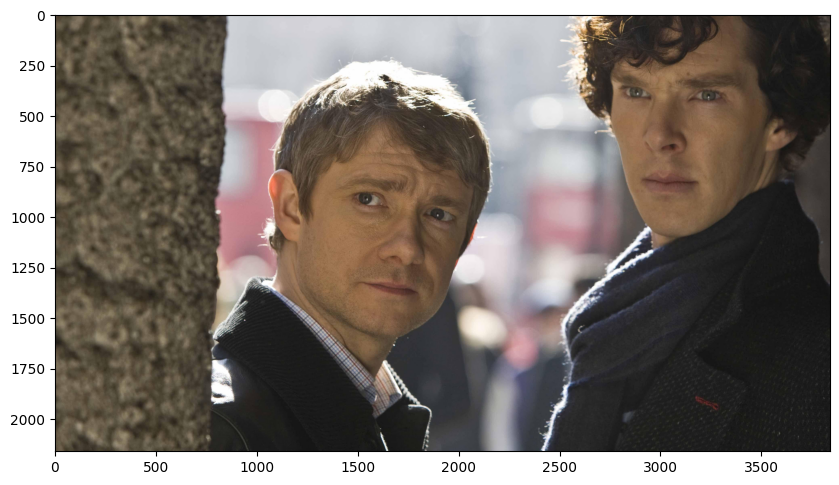

In [6]:
#Тестировать всё будем на следующем изображении:
img_path = 'data/emotion_recog_data/video_capture/a408f56d3047140bb921f1457f29dca0ae80edebd3a8ed61ca78f2702274ac1f.jpg'
image = plt.imread(img_path)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

Было выбрано случайное изображение с достатосно четкими лицами. Решила взять больше одного лица, т.к. такая ситцация впольне реальна в случае нашей задачи.

В результате поисков возможных вариантов решения, было выявлено несколько удобных (и простых) в использовании методов экстрации лиц из изображений. Попробуем и сравним три из них - MTCNN, YuNet и рассмотренный в примере к заданию Haar Cascade.

### MTCNN (Multi-task Cascaded Convolutional Networks)

MTCNN[1] (Multi-task Cascaded Convolutional Networks) - это каскад свёрточных нейронных сетей. В модели используются 3 сети: P-Net, R-Net и O-net, причем каждая последующая нейронная сеть увеличивает точность прогноза. MTCNN считается достаточно точным методом и является базой для многих современных моделей детектирования лиц и других объектов.
1.https://arxiv.org/abs/1604.02878 (Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks)

Напишем функцию, которая, используя библиотеку mtcnn и встроенный в неё метод detect faces, будет находить лица на изображении:

In [7]:
def extract_face_from_image(image_path, required_size=(224, 224)):
    # Загрузка изображения по заданному пути
    image = plt.imread(image_path)
    detector = MTCNN()
    faces = detector.detect_faces(image)
    
    face_images = []
    
    
    for face in faces:
        # для каждого лица на фото найдем ограничивающий прямоугольник:
        x1, y1, width, height = face['box']
        x2, y2 = x1 + width, y1 + height
    
    
        # обрезка изображения до рамки лица
        face_boundary = image[y1:y2, x1:x2]

        # Приведем к нужному размеру для подачи в модель
        face_image = Image.fromarray(face_boundary)
        face_image = face_image.resize(required_size)
        face_array = np.asarray(face_image)
#         face_array = face_image[None, ...]
        face_images.append(face_array)
    
    return face_images

In [8]:
#Посмотрим на результаты и время реализации предсказания на основе модели:

In [19]:
%%time
extracted_faces_mtcnn = extract_face_from_image(img_path)
preds_mtcnn = make_prediction(extracted_faces_mtcnn)

2/2 [==============================] - 0s 11ms/step
CPU times: user 2.28 s, sys: 945 ms, total: 3.22 s
Wall time: 1.16 s


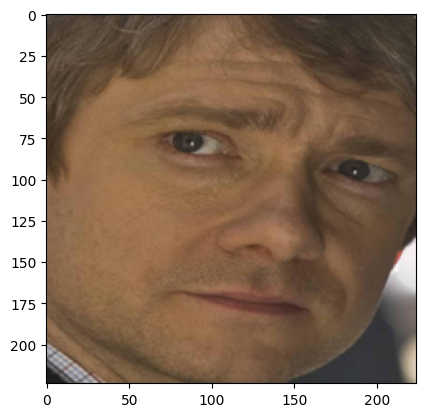

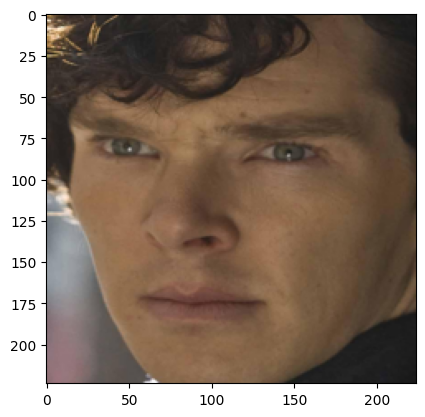

In [10]:
for face in extracted_faces_mtcnn:
    plt.imshow(face)
    plt.show()

Модель хорошо детектирует лица на изображении, но время инференсы составляет от 1 до 2 сек, что не подходит для нашей задачи.

### YuNet

YuNet — это детектор лиц на основе сверточной нейронной сети (CNN), разработанный Shiqi Yu[1,2] в 2018 году. YuNet обладает высокой точностью и производительностью в купе с быстродействием. Многие специалисты отмечают, что модель неплохо работает также и с нефронтальными изображениями лиц.
Ниже ссылки на оригинальный репозиторий модели и ссылка на статью автора YuNet с описанием приницпов работы модели.
1. https://github.com/ShiqiYu/libfacedetection
2. https://link.springer.com/article/10.1007/s11633-023-1423-y

In [11]:
# Инициализируем detector:
face_detector = cv2.FaceDetectorYN_create('data/YuNet/face_detection_yunet_2023mar.onnx',
                          "", 
                          (224, 224),
                          score_threshold=0.5)


def extract_face_YuNet(image_path, required_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(required_size)
    img = np.asarray(img)
    
    faces = face_detector.detect(img)[1]
    faces = faces.astype(int)

    
    face_images = []
    
    
    for face in faces:
        # для каждого лица на фото найдем ограничивающий прямоугольник:
        x1, y1, width, height = face[0], face[1], face[2], face[3]
        x2, y2 = x1 + width, y1 + height
    
    
        # обрезка изображения до рамки лица
        face_boundary = img[y1:y2, x1:x2]

        # Приведем к нужному размеру для подачи в модель
        face_image = Image.fromarray(face_boundary)
        face_image = face_image.resize(required_size)
        face_array = np.asarray(face_image)
#         face_array = face_array[None, ...]
        face_images.append(face_array)
    
    return face_images

In [12]:
%%time
extracted_faces_yunet = extract_face_YuNet(img_path)
preds_yunet = make_prediction(extracted_faces_yunet)

2/2 [==============================] - 0s 10ms/step
CPU times: user 152 ms, sys: 8.84 ms, total: 161 ms
Wall time: 142 ms


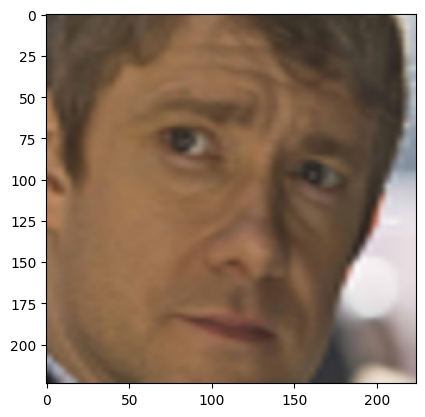

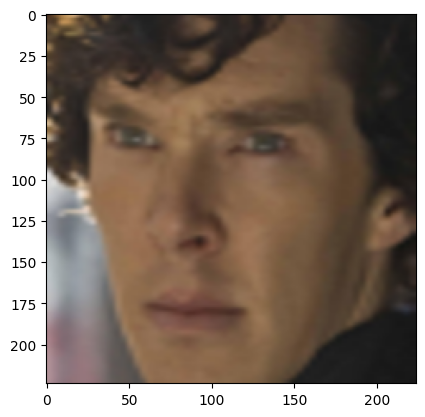

In [13]:
for face in extracted_faces_yunet:
    plt.imshow(face)
    plt.show()

Модель замечательно и достаточно быстро работает, хорошо подойдет в нашем случае.

### Haar face cascade

Каскадный классификатор Хаара - это алгоритм обнаружения объектов, который был предложен в 2001 году Полом Виолой и Майклом Джонсом в их статье «Быстрое обнаружение объектов с использованием расширенного каскада простых функций (Rapid Object Detection using a Boosted Cascade of Simple Features)».

Исходная реализация используется для обнаружения фронтальной части лица и его особенностей, таких как глаза, нос и рот. Однако на GitHub доступен предварительно обученный каскад HAAR для других объектов, например, для всего тела, верхней части тела, нижней части тела, улыбки и многого другого. Этот метод обнуружения лиц достаточно часто использвется новичками в связи со своей простотой использования, хотя по мнению ряда авторов он всё-таки немного устарел и плохо определяет лица в определенных ракурсах (поворот/наклон головы и т.д.).
Посмотрим заодно и его, т.к. в примере к заданию именно он и использовался, хотя есть сомнения в том, что он сможет "победить" YuNet.

In [14]:
#Загрузим файл с детектором:
face_cascade = cv2.CascadeClassifier('data/open_cv/haarcascade_frontalface_alt2.xml')

def cascade_face_from_image(detector, image_path, required_size=(224, 224), factor = 1.1, min_n = 5, face_size = (60, 60)):
    # Загрузка изображения по заданному пути
    image = plt.imread(image_path)
    img_copy = np.copy(image)
    gray_img = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    
    faces = detector.detectMultiScale(gray_img, scaleFactor=factor, minNeighbors=min_n, minSize=face_size)
    
    face_images = []
    
    
    for (x, y, w, h) in faces:
        # для каждого лица на фото найдем ограничивающий прямоугольник:
        x1, y1 = x + w, y + h
    
        # обрезка изображения до рамки лица
        face_boundary = image[y:y1, x:x1]

        # Приведем к нужному размеру для подачи в модель
        face_image = Image.fromarray(face_boundary)
        face_image = face_image.resize(required_size)
        face_array = np.asarray(face_image)
#         face_array = face_image[None, ...]
        face_images.append(face_array)
    
    return face_images

In [15]:
%%time
extracted_faces_haar = cascade_face_from_image(face_cascade, img_path)
preds_haar = make_prediction(extracted_faces_haar)

2/2 [==============================] - 0s 12ms/step
CPU times: user 1.08 s, sys: 74.7 ms, total: 1.15 s
Wall time: 202 ms


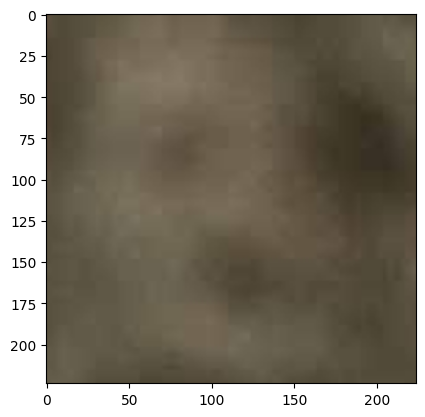

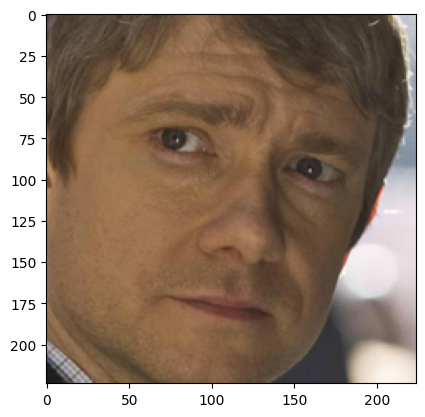

In [16]:
for face in extracted_faces_haar:
    plt.imshow(face)
    plt.show()

Забавно, детектор считает, что кусок стены больше похож на лицо человека, чем лицо актера Кумбербатча :) Попробуем поменять параметры и посмотреть на результат.

In [17]:
%%time
extracted_faces_haar = cascade_face_from_image(face_cascade, img_path, factor = 1.1, min_n = 3)
preds_haar = make_prediction(extracted_faces_haar)

3/3 [==============================] - 0s 9ms/step
CPU times: user 1.08 s, sys: 103 ms, total: 1.19 s
Wall time: 229 ms


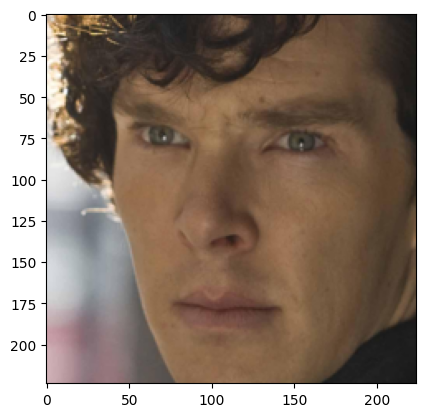

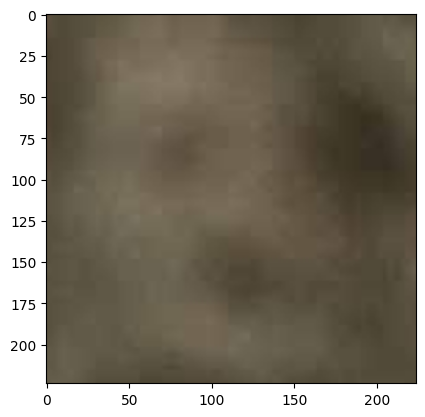

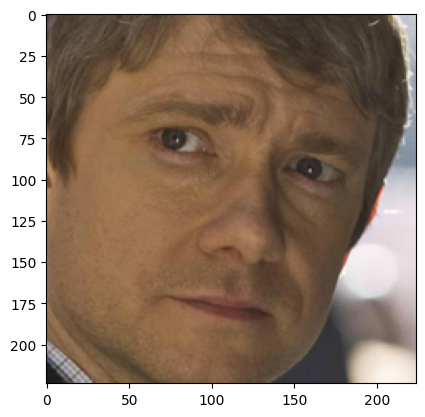

In [18]:
for face in extracted_faces_haar:
    plt.imshow(face)
    plt.show()

К сожалению изменение фактора и количества соседей не может повлиять на то, что детектор видит лицо в куске стены (ложное срабатывание).  С lbp_cascade дело обстоит еще хуже (также проверено). Так же присутствует момент, что для использования данного класса детекторов необходимо тщательно калибровать все вышепомянутые параметры под конкретную задачу, изображение и т.д., что в режиме детектирования в реальном времени достаточно накладно.

**Вывод:** Исходя из результатов выше, лучше всего для задачи детектирования в реальном времени использовать yunet, как достаточно быструю и точную модель детектирования лиц.